## Търсене и извличане на информация. Приложение на дълбоко машинно обучение
> ### Стоян Михов
> #### Зимен семестър 2021/2022

### Упражнение 7

 За да работи програмата трябва корпуса от публицистични текстове за Югоизточна Европа,
 да се намира разархивиран в директорията, в която е програмата (виж упражнение 2).

 Преди да се стартира програмата е необходимо да се активира съответното обкръжение с командата: `conda activate tii`
 
 Настоящата програма използва библиотеката sklearn.
 За да я инсталирате, след активиране на обкръжението трябва да изпълните командата: `conda install scikit-learn`

In [1]:
import nltk
from nltk.corpus import PlaintextCorpusReader
import sys
import random
import math
import pprint

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import TruncatedSVD

In [2]:
class progressBar:
    def __init__(self ,barWidth = 50):
        self.barWidth = barWidth
        self.period = None
    def start(self, count):
        self.item=0
        self.period = int(count / self.barWidth)
        sys.stdout.write("["+(" " * self.barWidth)+"]")
        sys.stdout.flush()
        sys.stdout.write("\b" * (self.barWidth+1))
    def tick(self):
        if self.item>0 and self.item % self.period == 0:
            sys.stdout.write("-")
            sys.stdout.flush()
        self.item += 1
    def stop(self):
        sys.stdout.write("]\n")

In [3]:
def extractDictionary(corpus, limit=20000):
    pb = progressBar()
    pb.start(len(corpus))
    dictionary = {}
    for doc in corpus:
        pb.tick()
        for w in doc:
            if w not in dictionary: dictionary[w] = 0
        dictionary[w] += 1
    L = sorted([(w,dictionary[w]) for w in dictionary], key = lambda x: x[1] , reverse=True)
    if limit > len(L): limit = len(L)
    words = [ w for w,_ in L[:limit] ]
    word2ind = { w:i for i,w in enumerate(words)}
    pb.stop()
    return words, word2ind

In [4]:
def co_occurrence_matrix(corpus, window_size=4, limit=20000):
    words, word2ind = extractDictionary(corpus,limit=limit)
    num_words = len(words)
    
    X=np.zeros((num_words,num_words))
    
    pb = progressBar()
    pb.start(len(corpus))
    for doc in corpus:
        pb.tick()
        for wi in range(len(doc)):
            if doc[wi] not in word2ind: continue
            i=word2ind[doc[wi]]
            for k in range(1,window_size+1):
                if wi-k>=0 and doc[wi-k] in word2ind:
                    j=word2ind[doc[wi-k]]
                    X[i,j] += 1
                if wi+k<len(doc) and doc[wi+k] in word2ind:
                    j=word2ind[doc[wi+k]]
                    X[i,j] += 1
    pb.stop()
    return X, words, word2ind

In [5]:
def PMI_matrix(C):
    rowSums = np.sum(C,axis=1)
    colSums = np.sum(C,axis=0)
    D = np.sum(rowSums)
    Z = np.outer(rowSums,colSums)
    X = np.maximum(np.log( D * C / Z),0)
    return X

In [6]:
def PCA_k_dim(X, k=2):
    # Документация на метода има на https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html

    print("Running Incremental PCA over %i words..." % (X.shape[0]))
    X0 = X - np.mean(X, axis=0)
    pca = IncrementalPCA(n_components=k)
    pca.fit(X0)
    X_reduced = pca.transform(X0)
    print("Done.")
    return X_reduced

In [7]:
def SVD_k_dim(X, k=100, n_iters = 10):
    # Документация на метода има на https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
    print("Running Truncated SVD over %i words..." % (X.shape[0]))
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    svd.fit(X)
    X_reduced = svd.transform(X)
    print("Done.")
    return X_reduced

In [8]:
def plot_embeddings(M, word2ind, words):
    xs = M[:,0]
    ys = M[:,1]
    for w in words:
        i=word2ind[w]
        plt.scatter(xs[i],ys[i], marker='x', color= 'red')
        plt.text(xs[i]+0.001, ys[i]+0.001, w)
    plt.show()

In [9]:
def plot_embeddings_3d(M, word2ind, words):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs = M[:,0]
    ys = M[:,1]
    zs = M[:,2]
    for w in words:
        i=word2ind[w]
        ax.scatter(xs[i], ys[i], zs[i], marker='x', color= 'red')
        ax.text(xs[i]+0.001, ys[i]+0.001, zs[i]+0.001, w)
    plt.show()

######   Пълен пример

In [10]:
corpus_root = '../JOURNALISM.BG/C-MassMedia'
myCorpus = PlaintextCorpusReader(corpus_root, '.*\.txt')
startToken = '<START>'
endToken = '<END>'
# corpus = [[startToken] + [w.lower() for w in myCorpus.words(f)] + [endToken] for f in myCorpus.fileids()]

In [11]:
pb = progressBar()
pb.start(len(myCorpus.fileids()))
corpus = []
for f in myCorpus.fileids():
    pb.tick()
    corpus.append([startToken] + [w.lower() for w in myCorpus.words(f)] + [endToken])
    
pb.stop()

[                                                  --------------------------------------------------]


In [11]:
C, words, word2ind = co_occurrence_matrix(corpus)
X = PMI_matrix(C)
X_reduced = SVD_k_dim(X)
X_reduced_3d = X_reduced[:,:3]
X_lengths_3d = np.linalg.norm(X_reduced_3d, axis=1)
X_normalized_3d = X_reduced_3d / X_lengths_3d[:, np.newaxis]

[                                                  --------------------------------------------------]
[                                                  --------------------------------------------------]


C:\Users\muchd\anaconda3\envs\tii\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


Running Truncated SVD over 20000 words...
Done.


In [12]:
sampleWords = ['кола', 'автомобил', 'румъния', 'министър', 'президент', 'гърция', 'футбол', 'спорт', 'баскетбол', 'българия', 'театър', 'кино', 'опера']

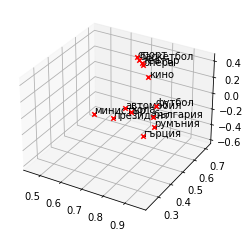

In [13]:
plot_embeddings_3d(X_normalized_3d, word2ind, sampleWords)

In [14]:
X_lengths_100d = np.linalg.norm(X_reduced, axis=1)
X_normalized_100d = X_reduced / X_lengths_100d[:, np.newaxis]

In [15]:
def most_similar(w,word2ind,words,C,limit=10):
    i = word2ind[w]
    L = np.dot(C,C[i]).tolist()
    L = sorted([(words[i],s) for i,s in enumerate(L)], key = lambda x: x[1] , reverse=True)
    return L[:limit]

In [16]:
pprint.pprint(most_similar('гърция',word2ind,words,X_normalized_100d))
pprint.pprint(most_similar('футбол',word2ind,words,X_normalized_100d))
pprint.pprint(most_similar('камион',word2ind,words,X_normalized_100d))

[('гърция', 0.9999999999999999),
 ('турция', 0.7759455992143587),
 ('албания', 0.7521069703180058),
 ('атина', 0.7411055289708357),
 ('хърватия', 0.7311764324962078),
 ('българия', 0.7255039732770048),
 ('кипър', 0.7253380805107794),
 ('румъния', 0.721914934838893),
 ('македония', 0.7086532828754081),
 ('страната', 0.6934585457347657)]
[('футбол', 1.0000000000000002),
 ('отбор', 0.8728341797692329),
 ('хандбал', 0.8500535393795767),
 ('баскетбол', 0.8473630620764148),
 ('топка', 0.8114870052338525),
 ('квалификациите', 0.8030917580513164),
 ('отборът', 0.8020611807818909),
 ('отбора', 0.7893088805940114),
 ('волейбол', 0.7867706693414529),
 ('водна', 0.7786400940714389)]
[('камион', 0.9999999999999998),
 ('автомобил', 0.8706230911360946),
 ('кола', 0.8170926627318839),
 ('колата', 0.7999615786338624),
 ('влак', 0.7924870091018097),
 ('скрити', 0.7755212386980317),
 ('огън', 0.7688276370908345),
 ('контейнер', 0.7666654110569575),
 ('скрит', 0.7573055271746855),
 ('шофиран', 0.754207874

#############################################################

In [17]:
def naiveSeed(X, K):
    return X[np.random.choice(np.arange(X.shape[0]),K)]

In [18]:
def Kmeans(X, K, selectSeed, maxIter=100, minRSSDelta=1e-4):
    #### X : Тензор с размер SxN, където S е броя на векторите, а N е размерността на векторите
    #### K : брой на клъстерите

    M = selectSeed(X, K) # размерността на M е KxN
    RSS=1e100

    iter=0

    while iter < 2 or (RSS0 - RSS > minRSSDelta  and iter < maxIter):
        RSS0=RSS

        M1 = np.expand_dims(M,axis=1) # размерността на M1 е Kx1xN
        
        X1 = np.expand_dims(X,axis=0) # размерността на X1 е 1xSxN
        
        XM = X1 - M1                  # размерността на XM е KxSxN
            
        R = np.sum(XM ** 2, axis=2)   # размерността на R е KxS -- k-тия ред ни дава разстоянието на квадрат на j-тия вектор до k-тия центроид M[k]

        W = np.argmin(R, axis=0)      # I е S-мерен вектор -- всеки елемент ни дава индекса на най-близкия центроид

        RS = R[W,np.arange(R.shape[1])] # квадрата на разстоянието до най-близкия центроид

        RSS = np.sum(RS)
        
        print(iter,RSS)
        
        M = np.stack([ np.mean(X[np.where(W==k)],axis=0) for k in range(K) ])
            # np.where(W==k) връща вектор от индексите i на W, за които W[i] == k
            # X[np.where(W==k)] е матрицата, от векторите (редове) на X, които са най-близко до k-тия центроид M[k]
            # np.mean(X[np.where(W==k)],axis=0) е центроида на векторите най-близко до M[k]
            # Накрая съставяме новата матрица M като събираме получените нови центроиди
            # Може ли без for?
        
        iter += 1
    return M

In [25]:
fileNames = myCorpus.fileids()
ecoCorpus = [ [startToken] + [w.lower() for w in myCorpus.words(f)] + [endToken] for f in fileNames if f.find('E-Economy'+'/')==0 ]
milCorpus = [ [startToken] + [w.lower() for w in myCorpus.words(f)] + [endToken] for f in fileNames if f.find('S-Military'+'/')==0 ]
culCorpus = [ [startToken] + [w.lower() for w in myCorpus.words(f)] + [endToken] for f in fileNames if f.find('C-Culture'+'/')==0 ]
polCorpus = [ [startToken] + [w.lower() for w in myCorpus.words(f)] + [endToken] for f in fileNames if f.find('J-Politics'+'/')==0 ]

In [26]:
corpus = ecoCorpus[:100]+milCorpus[:100]+culCorpus[:100]

In [27]:
def docVector(document, Embedding, word2ind):
    tf = np.zeros(len(word2ind))
    for w in document:
        if w in word2ind:
            tf[word2ind[w]] += 1
    return np.dot(tf,Embedding)

In [28]:
def corpusEmbedding(corpus, Embedding, word2ind):
    return np.stack([ docVector(doc, Embedding, word2ind) for doc in corpus ])

In [64]:
CE = corpusEmbedding(corpus, X_normalized_100d, word2ind)
CE_3d = CE[:,:3]
CE_3d = CE_3d / np.linalg.norm(CE_3d, axis=1)[:, np.newaxis]

In [59]:
def rotateZ(θ):
    return np.matrix([[np.cos(θ), -np.sin(θ), 0],\
            [np.sin(θ),  np.cos(θ), 0],\
            [        0,          0, 1]])

In [60]:
def rotateX(θ):
    return np.matrix([[        1,          0,          0],\
            [        0,  np.cos(θ), -np.sin(θ)],\
            [        0,  np.sin(θ),  np.cos(θ)]])

In [61]:
π=np.pi;π

3.141592653589793

In [65]:
CE_3d = np.dot(CE_3d, np.dot(rotateZ(π/2), rotateX(π/4)))

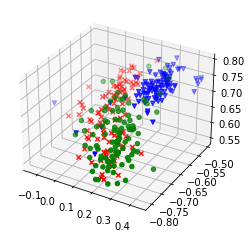

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(CE_3d[:100,0], CE_3d[:100,1], CE_3d[:100,2], marker='x', color= 'red')
ax.scatter(CE_3d[100:200,0], CE_3d[100:200,1], CE_3d[100:200,2], marker='o', color= 'green')
ax.scatter(CE_3d[200:,0], CE_3d[200:,1], CE_3d[200:,2], marker='v', color= 'blue')
plt.show()

In [106]:
M = Kmeans(CE_3d, 3, naiveSeed)
R = np.sum((np.expand_dims(CE_3d,axis=0) - np.expand_dims(M,axis=1) ) ** 2, axis=2)
W = np.argmin(R, axis=0)

0 3.2230074181441606
1 1.6840487971110725
2 1.5352430789070954
3 1.5275148603239226
4 1.5254409202972705
5 1.5252514917527384
6 1.524613775683318
7 1.5244221816531205
8 1.5241797620079642
9 1.5241797620079642


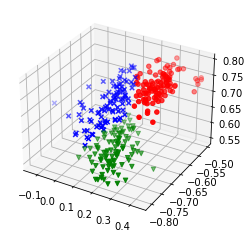

In [107]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(CE_3d[np.where(W==0),0], CE_3d[np.where(W==0),1], CE_3d[np.where(W==0),2], marker='x', color= 'blue')
ax.scatter(CE_3d[np.where(W==1),0], CE_3d[np.where(W==1),1], CE_3d[np.where(W==1),2], marker='o', color= 'red')
ax.scatter(CE_3d[np.where(W==2),0], CE_3d[np.where(W==2),1], CE_3d[np.where(W==2),2], marker='v', color= 'green')
plt.show()

In [57]:
fullCorpus = ecoCorpus + milCorpus + culCorpus + polCorpus
fCE = corpusEmbedding(fullCorpus, X_normalized_100d, word2ind)
fCE = fCE / np.linalg.norm(fCE, axis=1)[:, np.newaxis]

In [108]:
fM = Kmeans(fCE, 4, naiveSeed)
fR = np.sum((np.expand_dims(fCE,axis=0) - np.expand_dims(fM,axis=1) ) ** 2, axis=2)
fW = np.argmin(fR, axis=0)

0 467.47976485880207
1 312.18525936249847
2 298.1411591019151
3 292.21368931685447
4 289.53040703825496
5 288.1396398818348
6 287.3938058833791
7 286.8233270544424
8 286.3372330987498
9 285.9878942835483
10 285.6945697731434
11 285.3557115352407
12 285.01377721250674
13 284.6134440110662
14 284.23350726899963
15 283.89771540550737
16 283.67631007442895
17 283.47903480138865
18 283.3006539162274
19 283.13458280817025
20 282.985433551018
21 282.83766702014594
22 282.69604461003087
23 282.5903517533415
24 282.53617153071593
25 282.5109737250661
26 282.49616776872784
27 282.484661019659
28 282.47782631380034
29 282.47180126279596
30 282.46789436450234
31 282.466945712361
32 282.46602997778996
33 282.46576296094923
34 282.4655816193872
35 282.4654932492306


In [109]:
confusionMatrix = np.zeros((4,4),dtype='int32')
classCounts = [len(ecoCorpus), len(milCorpus), len(culCorpus), len(polCorpus)]
for i in range(len(classCounts)):
    sumUpToNow = sum(classCounts[:i])
    for d in range(sumUpToNow, sumUpToNow + classCounts[i]):
        confusionMatrix[i,fW[d]] += 1

In [110]:
classes = ['Economy','Military','Culture','Politics']
print('Матрица на обърквания: ')
print('{:8}'.format(''), end = '')
for col in range(confusionMatrix.shape[1]):
    print('{:8}'.format('      #'+str(col)), end = '')
print()
for row in range(confusionMatrix.shape[0]):
    print('{:8}'.format(classes[row]), end = '')
    for col in range(confusionMatrix.shape[1]):
        print('{:8}'.format(confusionMatrix[row,col]), end = '')
    print()

Матрица на обърквания: 
              #0      #1      #2      #3
Economy       30     166     181      69
Military     696     241     424      90
Culture        4       8      96      11
Politics     158    2260    1736    2202
